[WiDS 2025 | Baseline](https://www.kaggle.com/code/thiagomantuani/wids-2025-baseline)

In [1]:
#!pip install -q umap-learn

In [2]:
import numpy as np 
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import lightgbm as lgb, xgboost as xgb, catboost as cb
from gc import collect
import os
import matplotlib.pyplot as plt
import umap
from matplotlib.ticker import MaxNLocator
import scipy
import seaborn as sns
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures, MinMaxScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, roc_curve, make_scorer
from sklearn.feature_selection import RFECV, SequentialFeatureSelector, SelectKBest
from sklearn.linear_model import LogisticRegression, RidgeClassifier,RidgeClassifierCV
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE


# Load Data

In [3]:
def get_feats(mode='train'):
   
    feats=pd.read_excel(f"../input/widsdatathon2025/{mode}/{mode}_QUANTITATIVE_METADATA.xlsx")
    
    if mode=='TRAIN':
        cate=pd.read_excel(f"../input/widsdatathon2025/{mode}/{mode}_CATEGORICAL_METADATA.xlsx")
    else:
        cate=pd.read_excel(f"../input/widsdatathon2025/{mode}/{mode}_CATEGORICAL.xlsx")
    feats=feats.merge(cate,on='participant_id',how='left')
    
    func=pd.read_csv(f"../input/widsdatathon2025/{mode}/{mode}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
    feats=feats.merge(func,on='participant_id',how='left')

    if mode=='TRAIN':
        solution=pd.read_excel("../input/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx")
        feats=feats.merge(solution,on='participant_id',how='left')
        
    return feats
    


In [4]:
train = get_feats(mode='TRAIN')
test  = get_feats(mode='TEST')
sub   = pd.read_excel('../input/widsdatathon2025/SAMPLE_SUBMISSION.xlsx')
y     = pd.read_excel(f"../input/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx")

train.set_index('participant_id',inplace=True)
test.set_index('participant_id',inplace=True)
targets = ['ADHD_Outcome','Sex_F']
features = test.columns

In [5]:
def check_for_nulls(df):
  """
  Checks for null values in a pandas DataFrame and prints a message.

  Args:
    df: The pandas DataFrame to check.

  Returns:
    None
  """
  if df.isnull().any().any():
    print("The DataFrame contains null values.")
  else:
    print("The DataFrame does not contain null values.")

In [6]:
check_for_nulls(train)
check_for_nulls(test)
print(f'Train: {train.shape}, Test: {test.shape}')

The DataFrame contains null values.
The DataFrame contains null values.
Train: (1213, 19929), Test: (304, 19927)


* We have many features...

# Target's

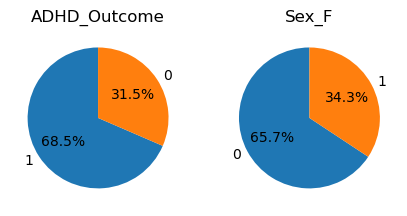

In [7]:
fig, axs = plt.subplots(1,2, figsize=(5,3))

for col, ax in zip(y.drop('participant_id',axis=1), axs):    
    counts = y[col].value_counts()
    ax.pie(counts, labels=counts.index, 
           autopct='%1.1f%%', 
           startangle=90)
    ax.set_title(f'{col}')

* We have a problem with unbalanced classes

# Model

* At first I will use a Ridge model

In [8]:
log_features = [f for f in features if (train[f] >= 0).all() and scipy.stats.skew(train[f]) > 0]

In [9]:
tup = train_test_split(
    train.drop(targets,axis=1), 
    y[targets], 
    test_size=0.70, # 0.30 was original
    random_state=42
)

X_train, X_test, y_train, y_test = tup


# Model Training and Evaluation

In this step, we train a Ridge Classifier model using a pipeline that includes data preprocessing steps such as imputation, logarithmic transformation, and scaling. The model is then evaluated using the F1 score.

- **MultiOutputClassifier**: This allows us to fit one classifier per target.
- **Pipeline**: Combines several preprocessing steps and the classifier into one.
    - **ColumnTransformer**: Applies different preprocessing steps to different columns.
        - **SimpleImputer**: Fills missing values.
        - **FunctionTransformer**: Applies a logarithmic transformation to specified features.
    - **MinMaxScaler**: Scales features to a given range.
    - **RidgeClassifier**: A linear classifier with L2 regularization.

The model is trained on the training data (`X_train`, `y_train`) and predictions are made on the test data (`X_test`). The performance is evaluated using the F1 score.


In [10]:


ct_1 = ColumnTransformer(
    transformers = [
        ('imputer', SimpleImputer(), features)
    ],
    remainder = 'passthrough',
    verbose_feature_names_out = False
)

ct_2 = ColumnTransformer(
    transformers = [
        ('log', FunctionTransformer(np.log1p), log_features)
    ],
    remainder = 'passthrough'
)

# *steps: list of Estimator objects
#     List of the scikit-learn estimators that are chained together.

steps = [
    ct_1.set_output(transform='pandas'), 
    ct_2,
    MinMaxScaler(),
    RidgeClassifier(alpha=100),
]

In [11]:
pipeline = make_pipeline(*steps)
pipeline

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer', SimpleImputer(),
                                                  Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total',
       ...
       '195throw_196thcolu...
                                                   'APQ_P_APQ_P_PM',
                                                   'SDQ_SDQ_Conduct_Problems',
                                                   'SDQ_SDQ_Difficulties_Total',
                                                   'SDQ_SDQ_Emotional_Problems',
                                                   'SDQ_SDQ_Externalizing',
                                                   'SDQ_SDQ_Generating_Impact',
                                                   'SDQ_SDQ_Internalizing',
                                                   'SDQ_SDQ_Peer_Problems',
                                                   'Basic_Demos_Study_Site',
                                                   'PreInt_Demos_Fam_Child_Race',
                                                   '26throw_129thcolumn'])])),
                ('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=100))])

In [12]:
model = MultiOutputClassifier(
    pipeline, 
    n_jobs=-1, # added this in to prevent crashing
)

In [13]:
print(
    f'X_train.shape = {X_train.shape}',
    f'y_train.shape = {y_train.shape}',
    sep='\n',
)

X_train.shape = (121, 19927)
y_train.shape = (121, 2)


In [15]:
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=Pipeline(steps=[('columntransformer-1',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('imputer',
                                                                                  SimpleImputer(),
                                                                                  Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulti...
                                                                                   'SDQ_SDQ_Conduct_Problems',
                                                                                   'SDQ_SDQ_Difficulties_Total',
                                                                                   'SDQ_SDQ_Emotional_Problems',
                                                                                   'SDQ_SDQ_Externalizing',
                                                                                   'SDQ_SDQ_Generating_Impact',
                                                                                   'SDQ_SDQ_Internalizing',
                                                                                   'SDQ_SDQ_Peer_Problems',
                                                                                   'Basic_Demos_Study_Site',
                                                                                   'PreInt_Demos_Fam_Child_Race',
                                                                                   '26throw_129thcolumn'])])),
                                                ('minmaxscaler',
                                                 MinMaxScaler()),
                                                ('ridgeclassifier',
                                                 RidgeClassifier(alpha=100))]),
                      n_jobs=-1)

In [ ]:
model.fit(
    X_train,
    y_train,
)

In [16]:
y_pred = model.predict(X_test)
print('f1: ', f1_score(y_test,y_pred,average='micro'))

f1:  0.6762719495722648


# Dimensionality reduction

## PCA

* PCA is particularly useful when dealing with high-dimensional datasets. We can try to improve our result by applying PCA
      

In [17]:
steps = [
    SimpleImputer(),
    StandardScaler(),
    PCA()
]

pca = make_pipeline(*steps)


: 

In [ ]:
1/0

In [ ]:
pca.fit(train[test.columns])
plt.figure(figsize=(7,5))
plt.plot(pca[-1].explained_variance_ratio_.cumsum())
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Principal Components Analysis')
plt.xlabel('component#')
plt.ylabel('explained variance ratio')
plt.yticks([0,0.5,0.85,0.90,0.95,1])
plt.xticks(range(0,1300,100))
plt.grid()
plt.show()

## UMAP

In [ ]:
pipe = make_pipeline(SimpleImputer(),MinMaxScaler())
reducer = umap.UMAP()
x_scaler = pipe.fit_transform(train[features])
reducer.fit(x_scaler)
_, axs = plt.subplots(1,2, figsize=(5,3), constrained_layout=True)
embedding = reducer.transform(x_scaler)
for t,ax in zip(targets,axs.ravel()):    
    ax.scatter(embedding[:, 0], embedding[:, 1], c=y[t], cmap='Spectral', s=5)
    plt.gca().set_aspect('equal', 'datalim')
    ax.set_title(f'{t}')
plt.suptitle('UMAP',fontsize=22);

* For ADHD_Outcome, there is some separation between the groups, but there is also overlap.
* For Sex_F, there is also overlap between the groups.

# Submission

In [12]:
model = MultiOutputClassifier(
   make_pipeline(ColumnTransformer([('imputer',SimpleImputer(),features)],
                                               remainder='passthrough',
                                               verbose_feature_names_out=False).set_output(transform='pandas'),
                                              ColumnTransformer([('log', 
                                                 FunctionTransformer(np.log1p), log_features)],
                                                 remainder='passthrough'),
                                            MinMaxScaler(),  
                                            PCA(1087),
                                            RidgeClassifier(alpha=100)))
model.fit(train.drop(targets,axis=1),
          y.drop('participant_id',axis=1))
y_pred = model.predict(test)
sub['ADHD_Outcome'] = y_pred[:,0]
sub['Sex_F'] = y_pred[:,1]
sub.to_csv('submission.csv',index=False)